In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas
import math
from hmmlearn import hmm
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from create_train_test_val_maps import *

In [2]:
#train_map_revived = open_map('/home/cs231n/data/train')
#val_map_revived = open_map('/home/cs231n/data/val')
#test_map_revived = open_map('/home/cs231n/data/test')


#val_map_deser_ok = open_ok_map('/home/cs231n/data/val30OK')
#train_map_deser_ok = open_ok_map('/home/cs231n/data/train30OK')
#test_map_deser_ok = open_ok_map('/home/cs231n/data/test30OK')
#val_map_deser = open_map('/home/cs231n/data/val30')
#train_map_deser = open_map('/home/cs231n/data/train30')
#test_map_deser = open_map('/home/cs231n/data/test30')
#val_combined = {**val_map_deser, **val_map_deser_ok}
#train_combined = {**train_map_deser, **train_map_deser_ok}
#test_combined = {**test_map_deser, **test_map_deser_ok}




pc_vec = pandas.read_pickle('pc_vec.pkl')
pc_vec2 = np.array(pc_vec['prob']).reshape((7,1))

cost_prob = np.genfromtxt('cost_prob.csv',delimiter=',')
cost_prob = cost_prob.T


selected_codes = [0,45021, 44004, 43004, 45008, 45002, 45007] # first code is the ok
selected_codes = list(np.sort(selected_codes))
num_codes = len(selected_codes)

In [3]:
selected_repairs = pandas.read_pickle('cleaned_selected_repairs.pkl')
veh_repair_cost_map = {}

for idx, row in selected_repairs.iterrows():
    veh_id = row['Chassis\nReference\nNumber']
    if veh_id not in veh_repair_cost_map:
        veh_repair_cost_map[veh_id] = {}
    cost_str = row['Repair Cost']
    cost = 0
    if cost_str == 'very low':
        cost = 1
    elif cost_str == 'low':
        cost = 2
    elif cost_str == 'medium':
        cost = 3
    elif cost_str == 'high ':
        cost = 4
    elif cost_str == 'very high':
        cost = 5
    if cost==0:
        print("error: {}".format(veh_id))
    veh_repair_cost_map[veh_id][row['ATA6']] = cost

In [4]:
selected_repairs = pandas.read_pickle('cleaned_selected_repairs.pkl')
veh_repair_map = {}
for veh_id, repairs in selected_repairs.groupby(['Chassis\nReference\nNumber']):
    veh_repair_map[veh_id] = repairs['ATA6'].values

In [5]:
# get global index from (row, col) index
def sub2ind(array_shape, row, col):
    ind = row*array_shape[1] + col
    if row < 0 or row >= array_shape[0]:
        ind = -1
    if col < 0 or col >= array_shape[1]:
        ind = -1
    return ind

# get (row, col) index from global index
def ind2sub(array_shape, ind):
    row = int(ind) / array_shape[1]
    col = ind % array_shape[1]
    if ind < 0:
        row = -1
        col = -1
    if ind >=  array_shape[0]*array_shape[1]:
        row = -1
        col = -1
    return (row, col)

def softmax(x):
    """
    Compute softmax function for input. 
    Use tricks from previous assignment to avoid overflow
    """
    ### YOUR CODE HERE
    xshift = np.max(x, axis = 1)
    xshift = xshift.reshape((x.shape[0],1))
    x = x - xshift
    s = np.exp(x) / np.sum(np.exp(x),axis = 1).reshape((x.shape[0],1))
    ### END YOUR CODE
    return s

In [6]:
def start_train(selected_codes, train_map_revived, num_iter, num_states):
    models = {}
    codes = []
    code_window_map = {}
    for vehicleID in train_map_revived.keys():
        for ATA6code in train_map_revived[vehicleID].keys():
            if ATA6code not in selected_codes:
                continue
            if ATA6code not in code_window_map:
                code_window_map[ATA6code] = {}
            for time_window in train_map_revived[vehicleID][ATA6code].keys():
                if time_window not in code_window_map[ATA6code]:
                    code_window_map[ATA6code][time_window] = []
                for sequence_of_snapshots in train_map_revived[vehicleID][ATA6code][time_window]:
                    code_window_map[ATA6code][time_window].append(sequence_of_snapshots)

    for ATA6code in code_window_map.keys():
        for time_window in code_window_map[ATA6code].keys():
            lengths = []
            listofsequences = code_window_map[ATA6code][time_window]
            X = pandas.concat(listofsequences).as_matrix()
            for sequence in listofsequences:
                lengths.append(sequence.shape[0]) 
            models[(ATA6code, time_window)] = hmm.GaussianHMM(n_components=num_states, n_iter=num_iter).fit(X.astype(float),lengths)
    return models

In [8]:
def get_results(alpha,selected_codes,val_map_revived,veh_repair_map,num_time_windows, code_probs, cost_prob, vehicle_repair_cost_map):    
    # VALIDATION ACCURACY
    num_codes = len(selected_codes)
    lengths = []
    for vehicleID in val_map_revived.keys():
        for ATA6code in val_map_revived[vehicleID].keys():
            if ATA6code not in selected_codes:
                continue
            for time_window in val_map_revived[vehicleID][ATA6code].keys():
                lengths.append(len(val_map_revived[vehicleID][ATA6code][time_window]))
    num_val = sum(lengths)
    #print(num_val)

    sample = 0
    labels = []
    
    # mse scores
    code_scores_mse = np.ones(num_val)
    window_scores_mse = np.ones(num_val)
    cost_scores_mse = np.ones(num_val)
    
    # accuracy scores
    code_scores_acc = np.zeros(num_val)
    window_scores_acc = np.zeros(num_val)
    cost_scores_acc = np.zeros(num_val)
    
    log_likelihoods = np.zeros((num_val, num_codes, num_time_windows))
    probabilities = np.zeros((num_val, num_codes, num_time_windows))
    for vehicleID in val_map_revived.keys():
        for ATA6code in val_map_revived[vehicleID].keys():
            if ATA6code not in selected_codes:
                continue
            for time_window in val_map_revived[vehicleID][ATA6code].keys():
                for sequence_of_snapshots in val_map_revived[vehicleID][ATA6code][time_window]:
                    labels.append([selected_codes.index(ATA6code),time_window])
                    x = sequence_of_snapshots.as_matrix() 
                    for pair in models.keys():
                        c = selected_codes.index(pair[0])
                        w = pair[1]
                        if c == 0 & w == 0:
            
                            #continue
                            #print(x.shape)
                            temp_score = models[pair].score(x.astype(float))
                            for i in range(len(log_likelihoods[sample,c,:])):
                                log_likelihoods[sample,c,i] = temp_score
                        else:
                            #print(x.shape)
                            log_likelihoods[sample,c,w] = models[pair].score(x.astype(float))
                    
                    # Compute Softmax Prob Matrix
                    probabilities_temp = softmax(log_likelihoods[sample].reshape(1,num_codes*num_time_windows))
                    probabilities[sample] = probabilities_temp.reshape(num_codes, num_time_windows) 
                    posterior_code_probs = np.sum(probabilities[sample]*code_probs,axis=1).reshape(1,7)
                    #print(posterior_code_probs.shape)
                    #print(cost_prob.shape)
                    predicted_cost = np.argmax(np.dot(posterior_code_probs,cost_prob))
                    # Get marginal max 
                    argmax_window = np.argmax(np.dot(probabilities[sample].T,code_probs))
                    argmax_code = np.argmax(np.sum(probabilities[sample]*code_probs,axis=1))
                    #max_index = np.unravel_index(probabilities[sample].argmax(), probabilities[sample].shape)

                    # MSE
                    #----------
                    # code
                    if  argmax_code == selected_codes.index(ATA6code):
                        code_scores_mse[sample] = 0
                    elif vehicleID in veh_repair_map and selected_codes[argmax_code] in veh_repair_map[vehicleID]:
                        code_scores_mse[sample] = 1-alpha
                    # window
                    window_scores_mse[sample] = math.pow(argmax_window - time_window,2)
                    # cost
                    if vehicleID in vehicle_repair_cost_map and ATA6code in vehicle_repair_cost_map[vehicleID]:
                        cost_scores_mse[sample] = math.pow(predicted_cost - vehicle_repair_cost_map[vehicleID][ATA6code],2)
                    else:
                        cost_scores_mse[sample] = math.pow(predicted_cost - 0,2)
                    
                    # Accuracy
                    #----------
                    # code
                    #print('argmax_code: ', argmax_code)
                    #print('vehicleID: ', vehicleID)
                    if  argmax_code == selected_codes.index(ATA6code):
                        code_scores_acc[sample] = 1
                    elif vehicleID in veh_repair_map and selected_codes[argmax_code] in veh_repair_map[vehicleID]:
                        code_scores_acc[sample] = alpha
                    # window
                    window_scores_acc[sample] = 1.0/(1.0 + math.pow(argmax_window - time_window,2))
                    # cost
                    if vehicleID in vehicle_repair_cost_map and ATA6code in vehicle_repair_cost_map[vehicleID]:
                        cost_scores_acc[sample] = (predicted_cost == vehicle_repair_cost_map[vehicleID][ATA6code])
                    else:
                        cost_scores_acc[sample] = (predicted_cost == 0.0)
                    sample = sample+1        
    
    #print(code_scores_acc)
    labels = np.asarray(labels)
    code_error = np.mean(code_scores_mse)
    window_error = np.mean(window_scores_mse) 
    cost_error = np.mean(cost_scores_mse)
    code_accuracy = np.mean(code_scores_acc)
    window_accuracy = np.mean(window_scores_acc)
    cost_accuracy = np.mean(cost_scores_acc)
    
    return code_error, window_error, cost_error, code_accuracy, window_accuracy, cost_accuracy

In [10]:
code_errors ={}
window_errors = {}
cost_errors = {}
code_accuracies = {}
window_accuracies = {}
cost_accuracies = {}

num_states = 2
num_iter = 100
alpha = 0.5

for num_windows in range(10,100,10):
    for window_size in range(10,100,10):
        print('\ngetting maps for: ',num_windows,window_size)
        train_combined, val_combined, test_combined = load_maps(num_windows, window_size)
        print('training...')
        models = start_train(selected_codes, train_combined, num_iter, num_states)
        print('validating and getting results...')
        code_error, window_error, cost_error, code_accuracy, window_accuracy, cost_accuracy = get_results(alpha,selected_codes,val_combined,veh_repair_map,num_windows, pc_vec2, cost_prob, veh_repair_cost_map)
        print('ATA6 Code Error: ', code_error)
        print('ATA6 Code Accuracy: ', code_accuracy)
        print('Window Error: ', window_error)
        print('Window Accuracy: ', window_accuracy)
        print('Cost Error: ', cost_error)
        print('Cost Accuracy: ', cost_accuracy)
        code_errors[(num_windows,window_size)] = code_error
        window_errors[(num_windows,window_size)] = window_error
        cost_errors[(num_windows,window_size)] = window_error
        code_accuracies[(num_windows,window_size)] = code_accuracy
        window_accuracies[(num_windows,window_size)] = window_accuracy
        cost_accuracies[(num_windows,window_size)] = cost_accuracy


getting maps for:  10 10
training...
validating and getting results...
ATA6 Code Error:  0.447688564477
ATA6 Code Accuracy:  0.552311435523
Window Error:  21.9099756691
Window Accuracy:  0.344982097657
Cost Error:  2.34063260341
Cost Accuracy:  0.523114355231

getting maps for:  10 20
training...
validating and getting results...
ATA6 Code Error:  0.521390374332
ATA6 Code Accuracy:  0.478609625668
Window Error:  17.3235294118
Window Accuracy:  0.347337437307
Cost Error:  2.35294117647
Cost Accuracy:  0.44385026738

getting maps for:  10 30
training...
validating and getting results...
ATA6 Code Error:  0.487252124646
ATA6 Code Accuracy:  0.512747875354
Window Error:  20.104815864
Window Accuracy:  0.349085820686
Cost Error:  2.75920679887
Cost Accuracy:  0.439093484419

getting maps for:  10 40
training...
validating and getting results...
ATA6 Code Error:  0.477611940299
ATA6 Code Accuracy:  0.522388059701
Window Error:  25.5820895522
Window Accuracy:  0.325522989158
Cost Error:  2.6

KeyboardInterrupt: 

In [ ]:
import pickle



with open('filename.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('filename.pickle', 'rb') as handle:
    b = pickle.load(handle)

print a == b



In [15]:
import pickle

the_map = {'code_errors': code_errors, 'window_errors': window_errors, 'cost_errors': cost_errors, 'code_accuracies': code_accuracies, 'window_accuracies': window_accuracies, 'cost_accuracies': cost_accuracies}
with open('results.pkl', 'wb') as handle:
    pickle.dump(the_map, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [17]:
code_errors

{(10, 10): 0.44768856447688565,
 (10, 20): 0.52139037433155078,
 (10, 30): 0.48725212464589235,
 (10, 40): 0.47761194029850745,
 (10, 50): 0.49367088607594939,
 (10, 60): 0.44107744107744107,
 (10, 70): 0.55160142348754448,
 (10, 80): 0.64909090909090905,
 (10, 90): 0.6354961832061069,
 (20, 10): 0.56382978723404253,
 (20, 20): 0.49483775811209441,
 (20, 30): 0.46688741721854304,
 (20, 40): 0.52321428571428574,
 (20, 50): 0.52746212121212122,
 (20, 60): 0.94153225806451613,
 (20, 70): 0.94891304347826089,
 (20, 80): 0.97558139534883725,
 (20, 90): 0.97110552763819091,
 (30, 10): 0.57889822595704954,
 (30, 20): 0.45444566410537868,
 (30, 30): 0.53174603174603174,
 (30, 40): 0.91677762982689748,
 (30, 50): 0.95501474926253682,
 (30, 60): 0.93842364532019706,
 (30, 70): 0.95719489981785066,
 (30, 80): 0.96499999999999997,
 (30, 90): 0.96799116997792489,
 (40, 10): 0.55547391623806019,
 (40, 20): 0.46684350132625996,
 (40, 30): 0.94825870646766164,
 (40, 40): 0.92791762013729973,
 (40, 50)

In [32]:
code_errors_list= np.zeros((8,9))
code_accuracies_list= np.zeros((8,9))
window_errors_list= np.zeros((8,9))
window_accuracies_list= np.zeros((8,9))
cost_errors_list= np.zeros((8,9))
cost_accuracies_list = np.zeros((8,9))
i = 0
for num_windows in range(10,90,10):
    j = 0
    for window_size in range(10,100,10):
        code_errors_list[i,j] = code_errors[(num_windows, window_size)]
        code_accuracies_list[i,j] =code_accuracies[(num_windows, window_size)]
        window_errors_list[i,j] = window_errors[(num_windows, window_size)]
        window_accuracies_list[i,j] = window_accuracies[(num_windows, window_size)]
        cost_errors_list[i,j] = cost_errors[(num_windows, window_size)]
        cost_accuracies_list[i,j] = cost_accuracies[(num_windows, window_size)]
        j = j+1
    i = i+1


    

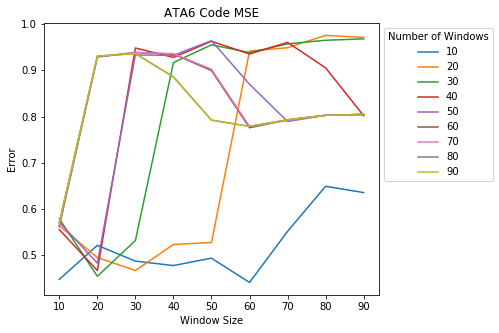

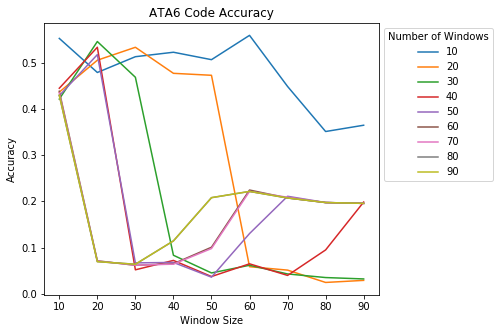

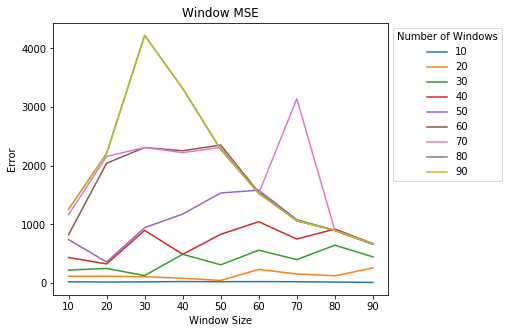

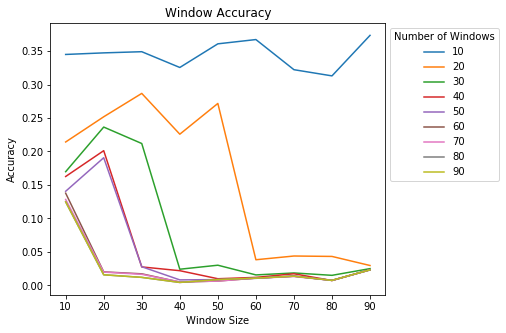

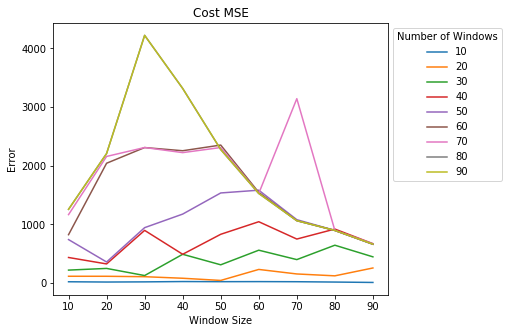

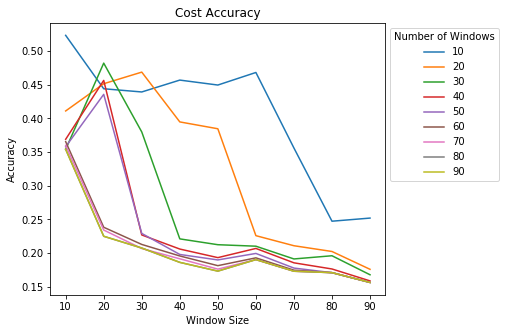

In [57]:

plt.figure()
get_plots(code_errors_list, "ATA6 Code MSE", "Window Size", "Error")
#plt.savefig('ATA6_Code_MSE')

plt.figure()
get_plots(code_accuracies_list, "ATA6 Code Accuracy", "Window Size", "Accuracy")
#plt.savefig('ATA6_Code_Accuracy')

plt.figure()
get_plots(window_errors_list, "Window MSE", "Window Size", "Error")
#plt.savefig('Window_MSE')

plt.figure()
get_plots(window_accuracies_list, "Window Accuracy", "Window Size", "Accuracy")
#plt.savefig('Window_Accuracy')

plt.figure()
get_plots(cost_errors_list, "Cost MSE", "Window Size", "Error")
#plt.savefig('Cost MSE')

plt.figure()
get_plots(cost_accuracies_list, "Cost Accuracy", "Window Size", "Accuracy")
#plt.savefig('Cost Accuracy')



In [56]:
def get_plots(Y,title, xlabel, ylabel):
    x = np.arange(10,100,10)
    plot_10 = plt.plot(x,Y[0,:],label='10')
    plot_20 = plt.plot(x,Y[1,:],label='20')
    plot_30 = plt.plot(x,Y[2,:],label='30')
    plot_40 = plt.plot(x,Y[3,:],label='40')
    plot_50 = plt.plot(x,Y[4,:],label='50')
    plot_60 = plt.plot(x,Y[5,:],label='60')
    plot_70 = plt.plot(x,Y[6,:],label='70')
    plot_80 = plt.plot(x,Y[7,:],label='80')
    plot_90 = plt.plot(x,Y[7,:],label='90')
    ax = plt.gca() # grab the current axis
    ax.set_xticks(np.arange(10,100,10)) # choose which x locations to have ticks
    ax.set_xticklabels(np.arange(10,100,10)) # set the labels to display at those ticks
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.suptitle("")
    plt.title(title)
    mylegend = plt.legend(loc="right corner",bbox_to_anchor=(1,1), title="Number of Windows")
    plt.rcParams["figure.figsize"] = [6,5]
    plt.savefig(title.replace(" ", "_"), bbox_extra_artists=(mylegend,), bbox_inches="tight")
    plt.show()

In [63]:
num_windows = 10
window_size = 10
print('\ngetting maps for: ',num_windows, window_size)
train_combined, val_combined, test_combined = load_maps(num_windows, window_size)
print('training...')
models = start_train(selected_codes, train_combined, num_iter, num_states)
print('validating and getting results...')
code_error, window_error, cost_error, code_accuracy, window_accuracy, cost_accuracy = get_results(alpha,selected_codes,val_combined,veh_repair_map,num_windows, pc_vec2, cost_prob, veh_repair_cost_map)
print('ATA6 Code Error: ', code_error)
print('ATA6 Code Accuracy: ', code_accuracy)
print('Window Error: ', window_error)
print('Window Accuracy: ', window_accuracy)
print('Cost Error: ', cost_error)
print('Cost Accuracy: ', cost_accuracy)


getting maps for:  10 10
training...
validating and getting results...
ATA6 Code Error:  0.448905109489
ATA6 Code Accuracy:  0.551094890511
Window Error:  21.8588807786
Window Accuracy:  0.345375135277
Cost Error:  2.34063260341
Cost Accuracy:  0.523114355231


In [65]:
(code_error + window_error + cost_error)/3

8.2161394971613948

In [66]:
(code_accuracy + window_accuracy + cost_accuracy)/3

0.47319479367296396